In [1]:
import pandas as pd
import xarray as xa
import subprocess
from matplotlib import pyplot as plt
import seaborn as sns
from wisdom.statistics import mode


In [2]:
sns.set_context("talk")
palette = "Spectral_r"


In [3]:
inference = xa.open_dataset("../outputs/model_inference_anon.nc")

In [9]:
global_concern = (
    inference
    .posterior_global_concerns
    .to_pandas()
    .apply(mode, axis=0, result_type="reduce")
    .rename("Overall Concern")
    .to_frame()
)

# Concern heatmap

In [6]:
inferred_labels = inference.inferred_labels.to_pandas()
label_uncertainties = inference.label_uncertainty.to_pandas() / 1000

In [7]:
df = (
    inferred_labels
    .stack()
    .rename("label")
    .to_frame()
    .join(
        label_uncertainties
        .stack()
        .rename("uncertainty")
    )
)
# this is the same as averaging all the draws
df["concern"] = df.apply(lambda x: x["uncertainty"] if x["label"]==1 else 1-x["uncertainty"], axis=1)
concerns = df.reset_index().pivot(index="enm", columns="hazard", values="concern")

Text(0.05, 0.95, 'A')

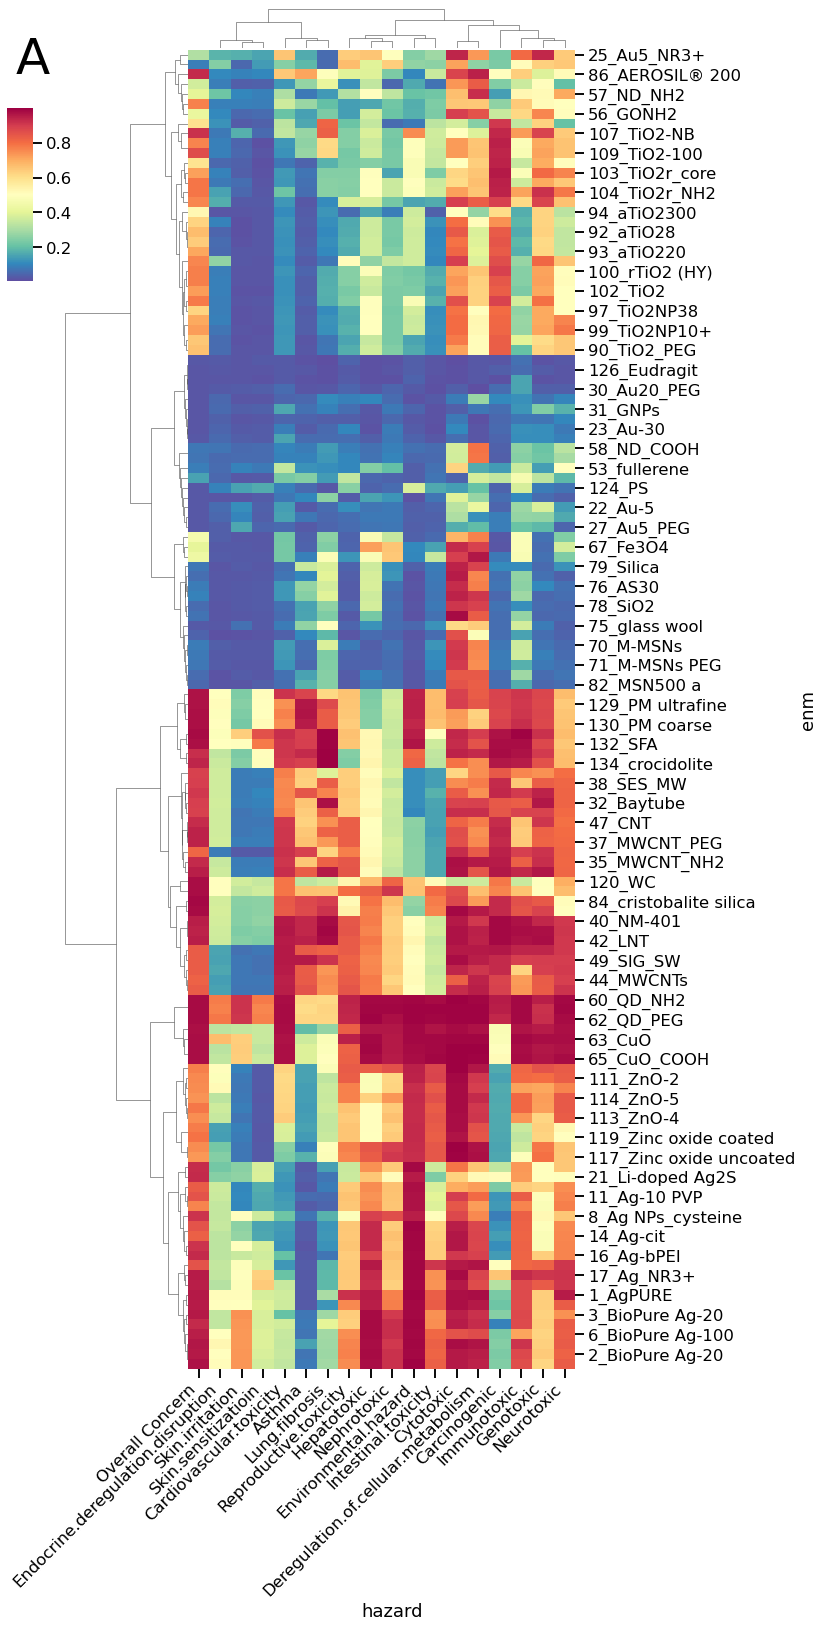

In [14]:
g=sns.clustermap(
    concerns,
    method="ward",
    figsize=(12, 24),
    cmap=sns.color_palette(palette, as_cmap=True),
    dendrogram_ratio=(0.25, 0.03),
    row_colors=global_concern["Overall Concern"].map(sns.color_palette(palette, as_cmap=True)),
    colors_ratio=0.04,
    xticklabels=1,
    yticklabels=2,
)
# g.ax_col_dendrogram.set_visible(False)

g.figure.subplots_adjust(left=0.1)
g.ax_cbar.set_position((0.04, 0.83, 0.03, 0.1))
_=plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, ha="left")
_=plt.setp(g.ax_row_colors.xaxis.get_majorticklabels(), rotation=45, ha="right")
_=plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha="right")

g.figure.text(0.05, 0.95, 'A', fontsize=50, transform=g.figure.transFigure)

# Overall concern by ENM class

In [15]:
categories = pd.read_csv("../data/enms_grouping.txt", sep="\t", header=None, names=["nano", "cat"])
concerns_cat = pd.merge(categories, global_concern, right_index=True, left_on="nano")
cat_order = concerns_cat.groupby("cat")["Overall Concern"].median().sort_values().index.to_list()

Text(0, 0.95, 'B')

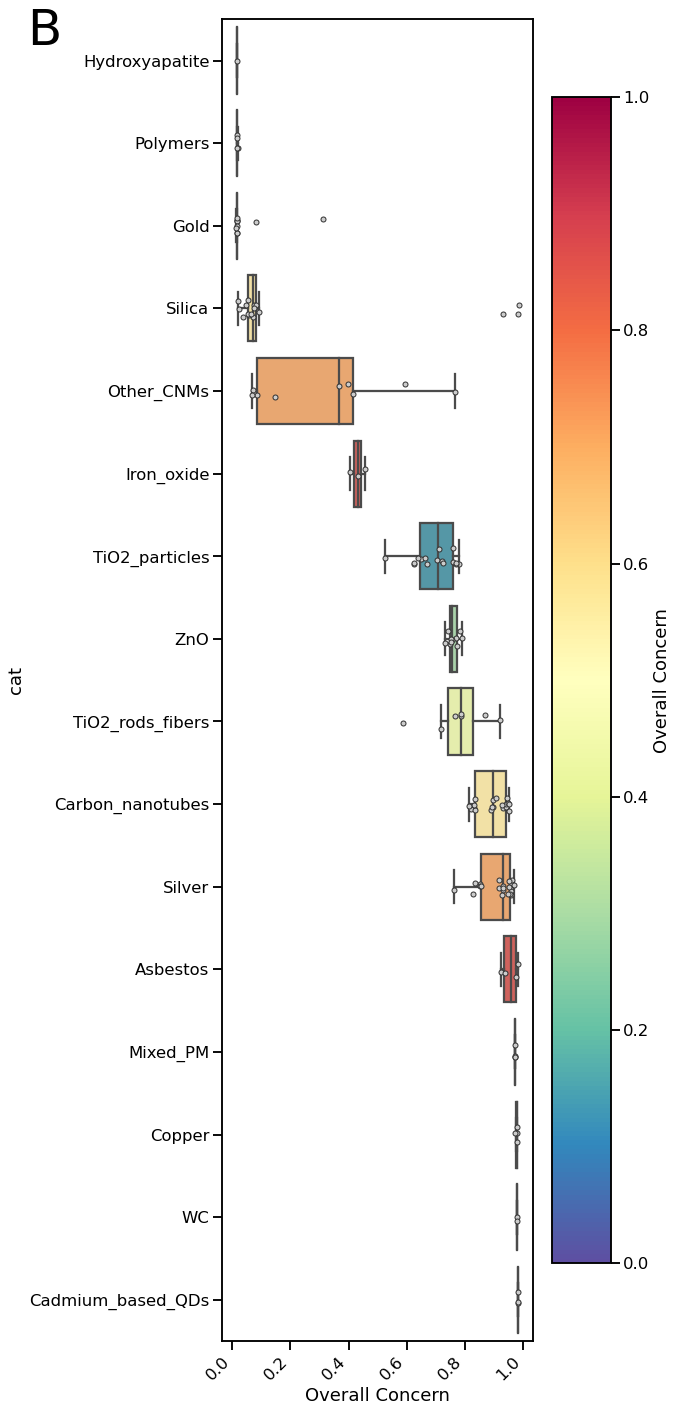

In [16]:
fig, ax = plt.subplots(figsize=(9, 24))
sns.boxplot(
    data=concerns_cat,
    y="cat",
    x="Overall Concern",
    order=cat_order,
    fliersize=0,
    orient="h",
    palette=sns.color_palette(palette),
    ax=ax,
)
sns.stripplot(
    data=concerns_cat,
    y="cat",
    x="Overall Concern",
    orient="h",
    order=cat_order,
    dodge=True,
    color="#CCC",
    linewidth=1,
    edgecolor="#333",
    ax=ax,
)
plt.xticks(rotation=45, ha="right")
cbar = ax.figure.colorbar(plt.cm.ScalarMappable(cmap=sns.color_palette(palette, as_cmap=True), norm=None), ax=ax)
cbar.set_label("Overall Concern")
fig.tight_layout()
fig.subplots_adjust(left=0.3, bottom=0.2, top=0.965, right=0.9)
fig.text(0, 0.95, 'B', fontsize=50, transform=fig.transFigure)

In [18]:
# !convert fig3A.png fig3B.pnb -gravity north +append figure3.png